In [ ]:
"""
Follow the py_v3_02_Lst-difference_240320.ipynb
对比有象区和无象区的LST差异,区分森林象和草原象，观察是否有降温效应
1.干旱期间LST差异，2015-2016年 （仅在15,16年发生干旱区域，15-16年都没发生干旱区域）
2.干旱前LST差异，2012-2014年均值 （三年发生过一次以上干旱区域，三年未发生干旱区域）
"""

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from openpyxl import load_workbook
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestRegressor
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'
sm_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
soil_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/RF/'
drv_path='//weili/User2/mxsun/CESS_230818/Pattern_drive/'
ele_path='//weili/User2/mxsun/CESS_230818/elephant_active_area/IUCN/'

In [2]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#forest_mask*
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [3]:
LA=read_img(spei_path+'LA_extant_001_240320.tif')[0]
LC=read_img(spei_path+'LC_extant_001_240320.tif')[0]
print(LA.min(),LA.max())
print(LC.min(),LC.max())

0.0 2.0
0.0 1.0


# LST prepare

In [4]:
lst=read_img(spei_path+'lst_1516_afr_001.tif')[0]
lst=lst*0.02-273.15
lst_pre=read_img(spei_path+'MOD11_mean_2012-14_001.tif')[0]
lst_pre=lst_pre*0.02-273.15

# 15-16年

## mask prepare

In [5]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
#SPEI,2012,2013,2014,2015,2016
drought=read_img(spei_path+'SPEI_drought_spei1516_001sub_240504.tif')[0]

spei_afr=read_img(spei_path+'SPEI_drought2012_16_001sub_240503.tif')[0]
spei_afr.shape
NDA=np.sum(spei_afr[3:5],0) #2015-2016年都没发生干旱的区域
NDA[NDA>0]=np.nan
NDA[NDA==0]=1
NDA[np.isnan(NDA)]=0

In [6]:
ele=read_img(ele_path+'fireCCI_eleIUCN20_LA-LCextant_mask001_230523.tif')[0]
ele[ele>0]=1
print(ele.min(),ele.max())
#提取干旱区域的有象区和无象区
#干旱&草原象
dro_LA=drought*LA
dro_LA[dro_LA!=1]=np.nan
#干旱&森林象
dro_LC=drought*LC
dro_LC[dro_LC!=1]=np.nan
#干旱&non-ele
dro_Nele=drought-ele
dro_Nele[dro_Nele<1]=np.nan

#提取非干旱区的有象区和无象区
#干旱&草原象
Ndro_LA=NDA*LA
Ndro_LA[Ndro_LA!=1]=np.nan
#干旱&森林象
Ndro_LC=NDA*LC
Ndro_LC[Ndro_LC!=1]=np.nan
#非干旱&non-ele
Ndro_Nele=NDA-ele
Ndro_Nele[Ndro_Nele<1]=np.nan

0 1


## slide window

In [10]:
"""
2023/11/25
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr,loc
dist_pool=[dro_LA*mask,dro_LC*mask,dro_Nele*mask,Ndro_LA*mask,Ndro_LC*mask,Ndro_Nele*mask]
dist_name=['dro_LA','dro_LC','dro_Nele','Ndro_LA','Ndro_LC','Ndro_Nele']

aa=[]
aa_name=[]
for i in range(6):
    el=[25,dist_pool[i],lst]
    aa.append(el)
    aa_name.append('CoolingLALC_{}_lst_0.25deg_240505.npy'.format(dist_name[i]))
         
print(aa_name)

['CoolingLALC_dro_LA_lst_0.25deg_240505.npy', 'CoolingLALC_dro_LC_lst_0.25deg_240505.npy', 'CoolingLALC_dro_Nele_lst_0.25deg_240505.npy', 'CoolingLALC_Ndro_LA_lst_0.25deg_240505.npy', 'CoolingLALC_Ndro_LC_lst_0.25deg_240505.npy', 'CoolingLALC_Ndro_Nele_lst_0.25deg_240505.npy']


In [11]:
for i in range(6):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (29580)...
执行任务1 (29580)...
执行任务2 (29580)...
执行任务3 (29580)...
执行任务4 (29580)...
执行任务5 (29580)...


## 成对样点求Δ

In [7]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

def mask_geo(dem1,dem2,slo1,slo2):
    #创建地形控制，限制pired size两边地形差异
    #dem<200
    #slope<10
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dem_differ[dem_differ<-200]=np.nan
    dem_differ[dem_differ>200]=np.nan
    dem_differ[~np.isnan(dem_differ)]=1
    slo_differ[slo_differ<-10]=np.nan
    slo_differ[slo_differ>10]=np.nan
    slo_differ[~np.isnan(slo_differ)]=1
    # 每一层数据位置对应,建立mask
    dd_mask=np.ones((260,316))*dem_differ*slo_differ
    return dd_mask
#干旱期间和非干旱期间的无象区和py_v3_02_Lst-difference_240320.ipynb中的通用
#DEM和Slope和py_v3_02_Lst-difference_240320.ipynb中的通用
geo1=['dro_ele','dro_Nele']
geo3=['Ndro_ele','Ndro_Nele']
geo=[geo1,geo3]

geo_mask=[]
for i in range(2):
    dem1=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(geo[i][0],'dem'),allow_pickle=True)[0]
    dem2=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(geo[i][1],'dem'),allow_pickle=True)[0]
    slo1=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(geo[i][0],'slope'),allow_pickle=True)[0]
    slo2=np.load(spei_path+'Cooling_{}_{}_0.25deg_240505.npy'.format(geo[i][1],'slope'),allow_pickle=True)[0]
    geo_mask.append(mask_geo(dem1,dem2,slo1,slo2))

In [8]:
#——————————2015，2016年——————————
#-----------------干旱区域成对样点------------------
dist_name=['dro_LA','dro_LC','Ndro_LA','Ndro_LC']
lst_dro_LA=np.load(spei_path+'CoolingLALC_dro_LA_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_LC=np.load(spei_path+'CoolingLALC_dro_LC_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_Nele=np.load(spei_path+'CoolingLALC_dro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
#paired sites
delta_dro_LA=(lst_dro_LA-lst_dro_Nele)*geo_mask[0]##2015干旱&草原象
delta_dro_LA=kill_nan(delta_dro_LA)
delta_dro_LC=(lst_dro_LC-lst_dro_Nele)*geo_mask[0]#2015干旱&森林象
delta_dro_LC=kill_nan(delta_dro_LC)
#-----------------非干旱区域成对样点-----------------

lst_Ndro_LA=np.load(spei_path+'CoolingLALC_Ndro_LA_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_LC=np.load(spei_path+'CoolingLALC_Ndro_LC_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_Nele=np.load(spei_path+'CoolingLALC_Ndro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
#paired sites
delta_Ndro_LA=(lst_Ndro_LA-lst_Ndro_Nele)*geo_mask[1]#2015非干旱&草原象
delta_Ndro_LA=kill_nan(delta_Ndro_LA)
delta_Ndro_LC=(lst_Ndro_LC-lst_Ndro_Nele)*geo_mask[1]#2015非干旱&森林象
delta_Ndro_LC=kill_nan(delta_Ndro_LC)

In [9]:
len(delta_dro_LA),len(delta_dro_LC),len(delta_Ndro_LA),len(delta_Ndro_LC)

(1772, 1148, 3336, 877)

In [10]:
np.mean(delta_dro_LA),np.mean(delta_dro_LC),np.mean(delta_Ndro_LA),np.mean(delta_Ndro_LC)

(-0.3036790077088918,
 -0.13462176306322476,
 -0.282245007636164,
 -0.015682925112299118)

In [11]:
#标准误
stats.sem(delta_dro_LA),stats.sem(delta_dro_LC),stats.sem(delta_Ndro_LA),stats.sem(delta_Ndro_LC)

(0.036731878562519964,
 0.02485925528574305,
 0.028330078381506568,
 0.03660809790944521)

## Fig 2015-2016

### significants

In [12]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

#——————————-----------2015年——————————------------
ddt_drLA=del_nan(lst_dro_LA,lst_dro_Nele)
sta,p_ddt_drLA=stats.wilcoxon(ddt_drLA[0],ddt_drLA[1])
ddt_drLC=del_nan(lst_dro_LC,lst_dro_Nele)
sta,p_ddt_drLC=stats.wilcoxon(ddt_drLC[0],ddt_drLC[1])


ddt_NdrLA=del_nan(lst_Ndro_LA,lst_Ndro_Nele)
sta,p_ddt_NdrLA=stats.wilcoxon(ddt_NdrLA[0],ddt_NdrLA[1])
ddt_NdrLC=del_nan(lst_Ndro_LC,lst_Ndro_Nele)
sta,p_ddt_NdrLC=stats.wilcoxon(ddt_NdrLC[0],ddt_NdrLC[1])

p_ddt_drLA,p_ddt_drLC,p_ddt_NdrLA,p_ddt_NdrLC #p value of ndvi_res and csif_res

(1.454565341954625e-06,
 5.93069871274917e-09,
 1.7678810321403612e-09,
 0.02270574119254037)

### Fig pdf

In [13]:
df_delta=[[delta_dro_LA,delta_dro_LC],
          [delta_Ndro_LA,delta_Ndro_LC]]
pp=[[p_ddt_drLA,p_ddt_drLC],
    [p_ddt_NdrLA,p_ddt_NdrLC]]

-0.3036790077088918 [0.31141812]
-0.13462176306322476 [0.81029034]
-0.282245007636164 [0.32135963]
-0.015682925112299118 [0.72883705]


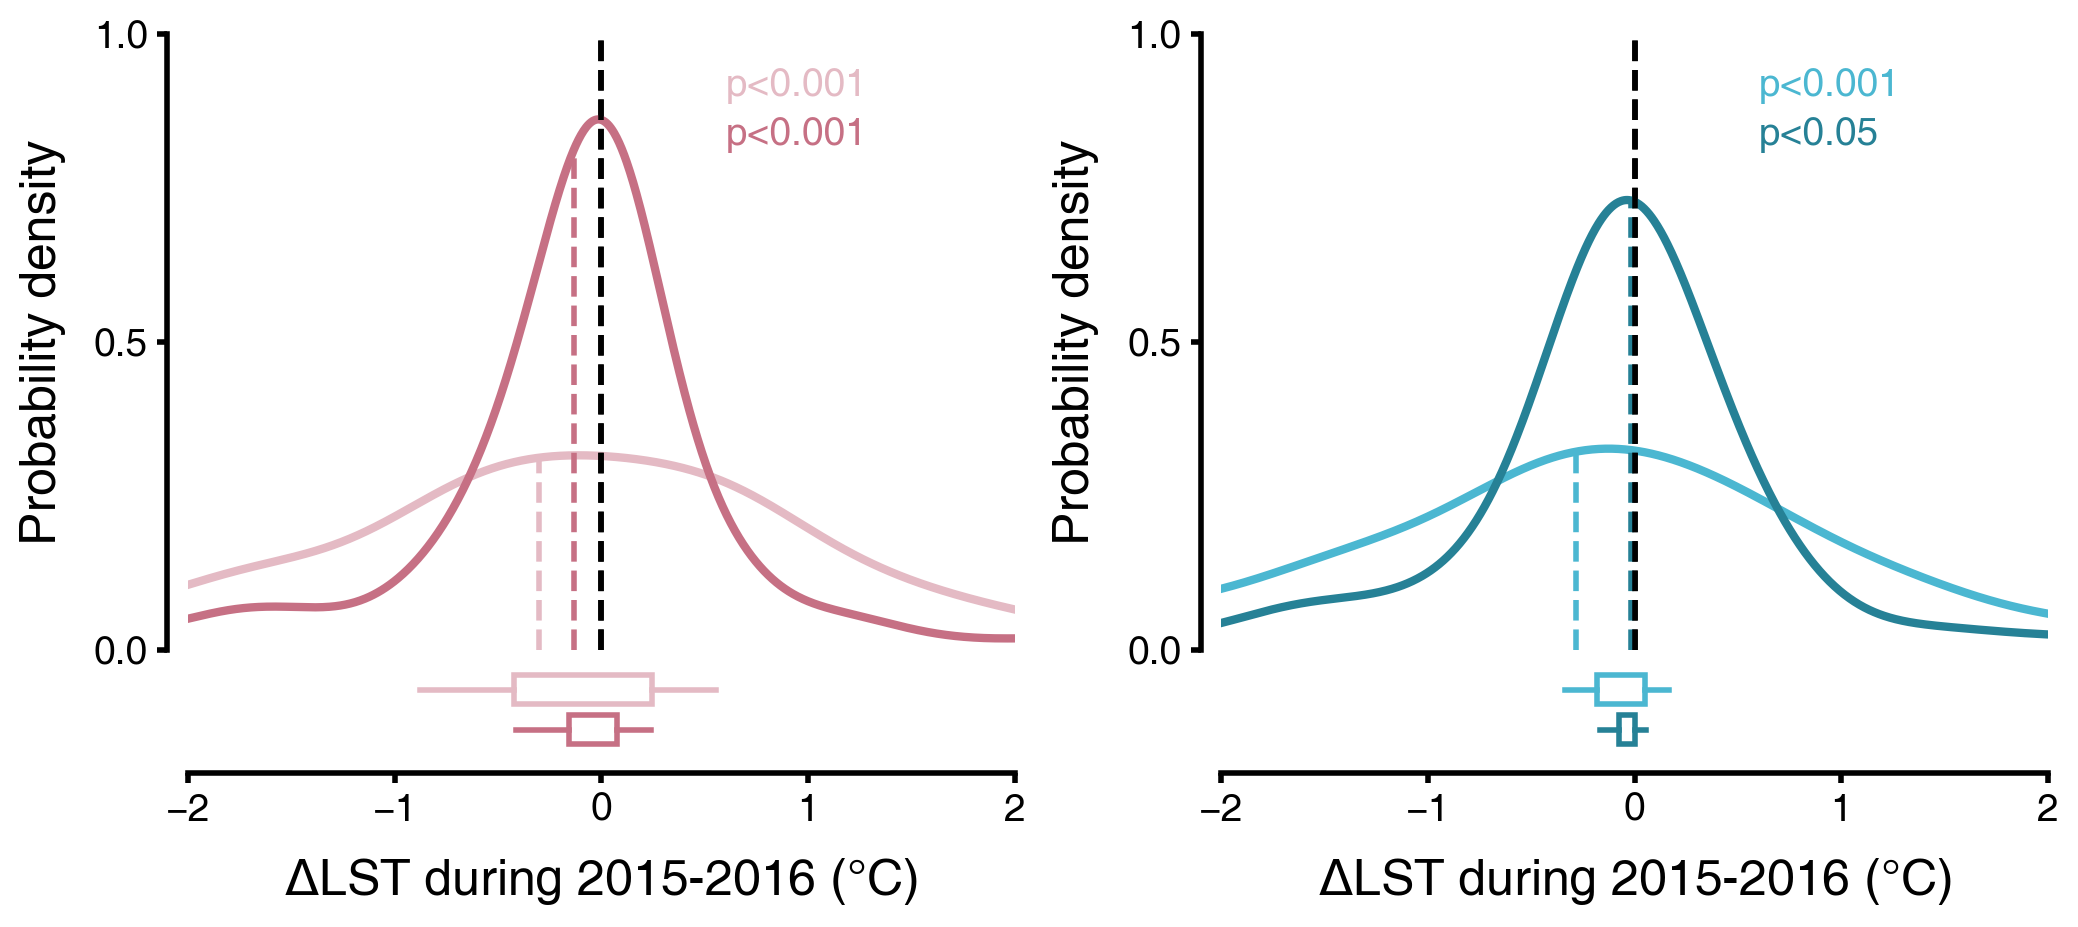

In [20]:
#-*- coding:utf-8 –*-
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(12,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 14}
plt.rc('font', **font)  #pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
#cl= np.array([(211,145,161),(231,195,204),(44,149,174),(115,200,219)])
cl1= np.array([(228,186,196),(198,112,132)])
cl2=np.array([(75,183,209),(38,129,150)])
cl=[cl1/255,cl2/255]
cl2=['C0','salmon']
label=[['Savanna elephants','Forest elephants'],
      ['Savanna elephants','Forest elephants']]
xlabel=['$\Delta$LST during 2015-2016 (°C)','$\Delta$LST during 2015-2016 (°C)']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    for j in range(2):
        x=np.linspace(-2,2,1000)
        mean=np.nanmean(df_delta[i][j])
        delta_rav=gc.nanravel(df_delta[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        ax.plot(x,z,lw=3,color=cl[i][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i][j])
        ax.vlines(0,0,1,lw=2,ls='--',color='black')
        if pp[i][j]<0.001:
            ax.text(0.65,0.90-j*0.08, 'p<0.001', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.01:
            ax.text(0.65,0.90-j*0.08, 'p<0.01', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.05:
            ax.text(0.65,0.90-j*0.08, 'p<0.05', fontsize=14,transform = ax.transAxes,color=cl[i][j])
        else:
            ax.text(0.65,0.90-j*0.08, 'p={:.2f}'.format(pp[i][j]), fontsize=14,transform = ax.transAxes,color=cl[i][j])
    #ax.legend(fontsize=14,loc='upper left',frameon=False)
    ax.set_xlim(-2,2)
    ax.set_xticks(np.arange(-2,2.01,1))
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1.1,0.5))
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-2.1))
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',-0.2))
    ax.set_ylabel('Probability density',labelpad=10)
    ax.set_xlabel(xlabel[0],labelpad=10)
    ax.tick_params(labelsize=14)
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(18)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    for j in range(2):
        if i ==0:
            if j ==0:
                ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.122,-0.05,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-5,5)
            ax1.set_xticks(np.arange(-5,5,2.5))
            ax1.axis('off')
        else:
            if j==0:
                ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.55,-0.05,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-15,15)
            ax1.set_xticks(np.arange(-15,15,5))
            ax1.axis('off')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
        #ax.spines['bottom'].set_visible(False)
        bplot=ax1.boxplot(df_delta[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i][j],"markeredgecolor":cl[i][j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i][j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i][j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i][j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i][j],'color':cl[i][j]})
    #ax.spines['bottom'].set_visible(False)
    #ax.legend(fontsize=14,loc=(0,-0.48),frameon=False)
#fig.savefig("E:/iCloudDrive/博后工作/文章/Elephant_disturb/Fig/reviseV2/Fig2_a-b.tif", dpi=600, bbox_inches = 'tight')

# 2012-2014

## mask prepare

In [15]:
spei_afr=read_img(spei_path+'SPEI_drought2012_16_001sub_240503.tif')[0]
pre_drought=np.sum(spei_afr[0:3],0) #2012-2014年发生过一次以上干旱
pre_drought[pre_drought>0]=1

pre_NDA=np.sum(spei_afr[0:3],0)#2012-2014年从未发生过干旱
pre_NDA[pre_NDA>0]=np.nan
pre_NDA[pre_NDA==0]=1
pre_NDA[np.isnan(pre_NDA)]=0

#提取干旱区域的有象区和无象区
#干旱&草原象
pre_dro_LA=pre_drought*LA
pre_dro_LA[pre_dro_LA!=1]=np.nan
#干旱&森林象
pre_dro_LC=pre_drought*LC
pre_dro_LC[pre_dro_LC<1]=np.nan
#干旱&non-ele
pre_dro_Nele=pre_drought-ele
pre_dro_Nele[pre_dro_Nele<1]=np.nan

#提取非干旱区的有象区和无象区
#干旱&草原象
pre_Ndro_LA=pre_NDA*LA
pre_Ndro_LA[pre_Ndro_LA!=1]=np.nan
#干旱&森林象
pre_Ndro_LC=pre_NDA*LC
pre_Ndro_LC[pre_Ndro_LC!=1]=np.nan
#非干旱&non-ele
pre_Ndro_Nele=pre_NDA-ele
pre_Ndro_Nele[pre_Ndro_Nele<1]=np.nan

In [16]:
#forest_mask=read_img(spei_path+'Africa_forest_area_240319.tif')[0]
hfp = read_img(spei_path+'hfp2018_Afirca_001_230525.tif')[0]
hfp[hfp<=15]=1
hfp[hfp>1]=np.nan
mask=hfp#forest_mask*
mask[~np.isnan(mask)]=1
np.nanmin(mask),np.nanmax(mask)

(1.0, 1.0)

In [27]:
"""
2023/11/25
supply paired sites methods. 
Be notes the  suppled detail locates should be consistence with all factors.
"""
# current shape:(6500,7900)
#0.01deg to 0.25 deg window size=625 pixels
#6500/25,7900/25...(260,316)
def slide_window_mean(s,dist,res):
    #s: window size
    #dist: disturb array
    #res: resistance and resilience array
    mean_arr=np.zeros((260,316))
    weight_arr=np.zeros((260,316))
    loc=np.zeros((260,316)) #record the location of supplied sites
    sl=np.ones((25,25))
    for i in range(260):
        #print("sliding", i, "line...")
        for j in range(316):
            bloc_dist=dist[i*s:(i+1)*s,j*s:(j+1)*s]
            res_dist=res[i*s:(i+1)*s,j*s:(j+1)*s]
            res_mask=np.multiply(bloc_dist,res_dist)#product restance array controled by window
            count=np.count_nonzero(~np.isnan(res_mask))
            weight=count/625#calculate the weight
            if weight>0.05:
                weight_arr[i,j]=weight
                dt=np.where(res_mask!=np.nan,res_mask,np.nan)
                mean_arr[i,j]=np.nanmean(res_mask)#calculate the mean value
                loc[i,j]=9
            else:
                bloc_dist_a=[] #should be 8 nums [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                res_dist_a=[] #should be 8 nums
                res_mask_pool=[]
                weight_pool=[]
                for m in [-1,1]:
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    bloc_dist_a.append(dist[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    bloc_dist_a.append(dist[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,j*s:(j+1)*s])
                    res_dist_a.append(res[i*s:(i+1)*s,(j+m)*s:((j+m)+1)*s])
                    res_dist_a.append(res[(i+m)*s:((i+m)+1)*s,(j+m)*s:((j+m)+1)*s])
                bloc_dist_a.append(dist[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                bloc_dist_a.append(dist[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                res_dist_a.append(res[(i-1)*s:((i-1)+1)*s,(j+1)*s:((j+1)+1)*s])
                res_dist_a.append(res[(i+1)*s:((i+1)+1)*s,(j-1)*s:((j-1)+1)*s])
                #the smooth order of a 9 value array is [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                for n in range(len(bloc_dist_a)): #the length is 8
                    res_mask_pool.append(np.multiply(bloc_dist_a[n],res_dist_a[n]))
                    weight_pool.append(np.count_nonzero(~np.isnan(res_mask_pool[n]))/625)#calculate the weight
                key=np.argmax(weight_pool) 
                # Key used to loc the supplied direction, the key-value consistience with [-1,0],[0,-1],[-1,-1],[1,0],[0,1],[1,1],[-1,1],[1,-1]
                if weight_pool[key] > 0.05:
                    weight_arr[i,j]=weight_pool[key]
                    dt1=np.where(res_mask_pool[key]!=np.nan,res_mask_pool[key],np.nan)
                    mean_arr[i,j]=np.nanmean(dt1)#calculate the mean value
                    loc[i,j]=key+1
                else:
                    mean_arr[i,j]=np.nan#calculate the mean value
                    loc[i,j]=np.nan
    return mean_arr,loc
dist_pool=[pre_dro_LA*mask,pre_dro_LC*mask,pre_dro_Nele*mask,pre_Ndro_LA*mask,pre_Ndro_LC*mask,pre_Ndro_Nele*mask]
dist_name=['pre_dro_LA','pre_dro_LC','pre_dro_Nele','pre_Ndro_LA','pre_Ndro_LC','pre_Ndro_Nele']

aa=[]
aa_name=[]
for i in range(6):
    el=[25,dist_pool[i],lst_pre]
    aa.append(el)
    aa_name.append('CoolingLALC_{}_lst_0.25deg_240505.npy'.format(dist_name[i]))
         
print(aa_name)

['CoolingLALC_pre_dro_LA_lst_0.25deg_240505.npy', 'CoolingLALC_pre_dro_LC_lst_0.25deg_240505.npy', 'CoolingLALC_pre_dro_Nele_lst_0.25deg_240505.npy', 'CoolingLALC_pre_Ndro_LA_lst_0.25deg_240505.npy', 'CoolingLALC_pre_Ndro_LC_lst_0.25deg_240505.npy', 'CoolingLALC_pre_Ndro_Nele_lst_0.25deg_240505.npy']


In [28]:
for i in range(6):
    print('执行任务%s (%s)...' % (i, os.getpid()))
    kk=slide_window_mean(aa[i][0],aa[i][1],aa[i][2])
    np.save(spei_path+aa_name[i],kk)

执行任务0 (29580)...
执行任务1 (29580)...
执行任务2 (29580)...
执行任务3 (29580)...
执行任务4 (29580)...
执行任务5 (29580)...


In [32]:
dem=read_img(spei_path+'gtopoDEM_afr_001.tif')[0]
slope=read_img(spei_path+'gtopoSlope_afr_001.tif')[0]
print('dem',dem.min(),dem.max())
print('slope',slope.min(),slope.max())
dem=dem.astype(np.float32)
dem[dem==-9999]=np.nan
slope[slope==0]=np.nan

dem -9999 5438
slope -3.402823e+38 79.12291


In [33]:
#DEM和Slope paireds
geo=[dem,slope]
geo_name=['dem','slope']
for i in range(6):
    for j in range(2):
        kk=slide_window_mean(25,dist_pool[i],geo[j])
        np.save(spei_path+'CoolingLALC_{}_{}_0.25deg_240505.npy'.format(dist_name[i],geo_name[j]),kk)

C:\Users\dess\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


## 成对样点求Δ

In [21]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

def mask_geo(dem1,dem2,slo1,slo2):
    #创建地形控制，限制pired size两边地形差异
    #dem<200
    #slope<10
    dem_differ=dem1-dem2
    slo_differ=slo1-slo2
    dem_differ[dem_differ<-200]=np.nan
    dem_differ[dem_differ>200]=np.nan
    dem_differ[~np.isnan(dem_differ)]=1
    slo_differ[slo_differ<-10]=np.nan
    slo_differ[slo_differ>10]=np.nan
    slo_differ[~np.isnan(slo_differ)]=1
    # 每一层数据位置对应,建立mask
    dd_mask=np.ones((260,316))*dem_differ*slo_differ
    return dd_mask
#干旱期间和非干旱期间的无象区和py_v3_02_Lst-difference_240320.ipynb中的通用
#DEM和Slope和py_v3_02_Lst-difference_240320.ipynb中的通用
#dist_name=['pre_dro_LA','pre_dro_LC','pre_dro_Nele','pre_Ndro_LA','pre_Ndro_LC','pre_Ndro_Nele']
geo1=['pre_dro_LA','pre_dro_Nele']
geo2=['pre_dro_LC','pre_dro_Nele']
geo3=['pre_Ndro_LA','pre_Ndro_Nele']
geo4=['pre_Ndro_LC','pre_Ndro_Nele']
geo=[geo1,geo2,geo3,geo4]

geo_mask=[]
for i in range(4):
    dem1=np.load(spei_path+'CoolingLALC_{}_{}_0.25deg_240505.npy'.format(geo[i][0],'dem'),allow_pickle=True)[0]
    dem2=np.load(spei_path+'CoolingLALC_{}_{}_0.25deg_240505.npy'.format(geo[i][1],'dem'),allow_pickle=True)[0]
    slo1=np.load(spei_path+'CoolingLALC_{}_{}_0.25deg_240505.npy'.format(geo[i][0],'slope'),allow_pickle=True)[0]
    slo2=np.load(spei_path+'CoolingLALC_{}_{}_0.25deg_240505.npy'.format(geo[i][1],'slope'),allow_pickle=True)[0]
    geo_mask.append(mask_geo(dem1,dem2,slo1,slo2))

In [22]:
def kill_nan(dt):
    a=dt.ravel()
    a=a[~np.isnan(a)]
    a=list(a)
    return a

#——————————-----------2012-14年——————————------------
#-----------------干旱区域成对样点------------------
##干旱&草原象
lst_dro_LA=np.load(spei_path+'CoolingLALC_pre_dro_LA_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_Nele=np.load(spei_path+'CoolingLALC_pre_dro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_pre_dro_LA=(lst_dro_LA-lst_dro_Nele)*geo_mask[0]
delta_pre_dro_LA=kill_nan(delta_pre_dro_LA)
#干旱&森林象
lst_dro_LC=np.load(spei_path+'CoolingLALC_pre_dro_LC_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_dro_Nele=np.load(spei_path+'CoolingLALC_pre_dro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_pre_dro_LC=(lst_dro_LC-lst_dro_Nele)*geo_mask[1]
delta_pre_dro_LC=kill_nan(delta_pre_dro_LC)
#-----------------非干旱区域成对样点-----------------
#干旱&草原象
lst_Ndro_LA=np.load(spei_path+'CoolingLALC_pre_Ndro_LA_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_Nele=np.load(spei_path+'CoolingLALC_pre_Ndro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_pre_Ndro_LA=(lst_Ndro_LA-lst_Ndro_Nele)*geo_mask[2]
delta_pre_Ndro_LA=kill_nan(delta_pre_Ndro_LA)
#干旱&森林象
lst_Ndro_LC=np.load(spei_path+'CoolingLALC_pre_Ndro_LC_lst_0.25deg_240505.npy',allow_pickle=True)[0]
lst_Ndro_Nele=np.load(spei_path+'CoolingLALC_pre_Ndro_Nele_lst_0.25deg_240505.npy',allow_pickle=True)[0]
delta_pre_Ndro_LC=(lst_Ndro_LC-lst_Ndro_Nele)*geo_mask[3]
delta_pre_Ndro_LC=kill_nan(delta_pre_Ndro_LC)

In [23]:
len(delta_pre_dro_LA),len(delta_pre_dro_LC),len(delta_pre_Ndro_LA),len(delta_pre_Ndro_LC)

(3088, 1711, 3060, 1317)

In [24]:
np.mean(delta_pre_dro_LA),np.mean(delta_pre_dro_LC),np.mean(delta_pre_Ndro_LA),np.mean(delta_pre_Ndro_LC)

(-0.2611028646848468,
 -0.20998802230507563,
 -0.3128225847942473,
 -0.10605403325150585)

## Fig 2012-14

### significants

In [25]:
def del_nan(data,data1):
    aa=np.where(np.isnan(data.ravel()))
    bb=np.where(np.isnan(data1.ravel()))
    kk=np.concatenate((aa,bb),axis=1)
    yy=np.unique(kk)
    data=np.delete(data.ravel(),yy)
    data1=np.delete(data1.ravel(),yy)
    return data, data1

#——————————-----------2012-14年——————————------------
#-----------------干旱区域成对样点------------------
##干旱&草原象
ddt_pre_drLA=del_nan(lst_dro_LA,lst_dro_Nele)
sta,p_ddt_pre_drLA=stats.wilcoxon(ddt_pre_drLA[0],ddt_pre_drLA[1])
#干旱&森林象
ddt_pre_drLC=del_nan(lst_dro_LC,lst_dro_Nele)
sta,p_ddt_pre_drLC=stats.wilcoxon(ddt_pre_drLC[0],ddt_pre_drLC[1])
#-----------------非干旱区域成对样点-----------------
#干旱&草原象
ddt_pre_NdrLA=del_nan(lst_Ndro_LA,lst_Ndro_Nele)
sta,p_ddt_pre_NdrLA=stats.wilcoxon(ddt_pre_NdrLA[0],ddt_pre_NdrLA[1])
#干旱&森林象
ddt_pre_NdrLC=del_nan(lst_Ndro_LC,lst_Ndro_Nele)
sta,p_ddt_pre_NdrLC=stats.wilcoxon(ddt_pre_NdrLC[0],ddt_pre_NdrLC[1])

p_ddt_pre_drLA,p_ddt_pre_drLC,p_ddt_pre_NdrLA,p_ddt_pre_NdrLC #p value of ndvi_res and csif_res

(1.155933616779937e-05,
 2.1554064554194633e-19,
 6.385281040087529e-12,
 1.200754293800272e-06)

### fig pdf

In [26]:
df_delta=[[delta_pre_dro_LA,delta_pre_dro_LC],
          [delta_pre_Ndro_LA,delta_pre_Ndro_LC]]
pp=[[p_ddt_pre_drLA,p_ddt_pre_drLC],
    [p_ddt_pre_NdrLA,p_ddt_pre_NdrLC]]

-0.2611028646848468 [0.32921824]
-0.20998802230507563 [0.68762039]
-0.3128225847942473 [0.33284566]
-0.10605403325150585 [0.79706711]


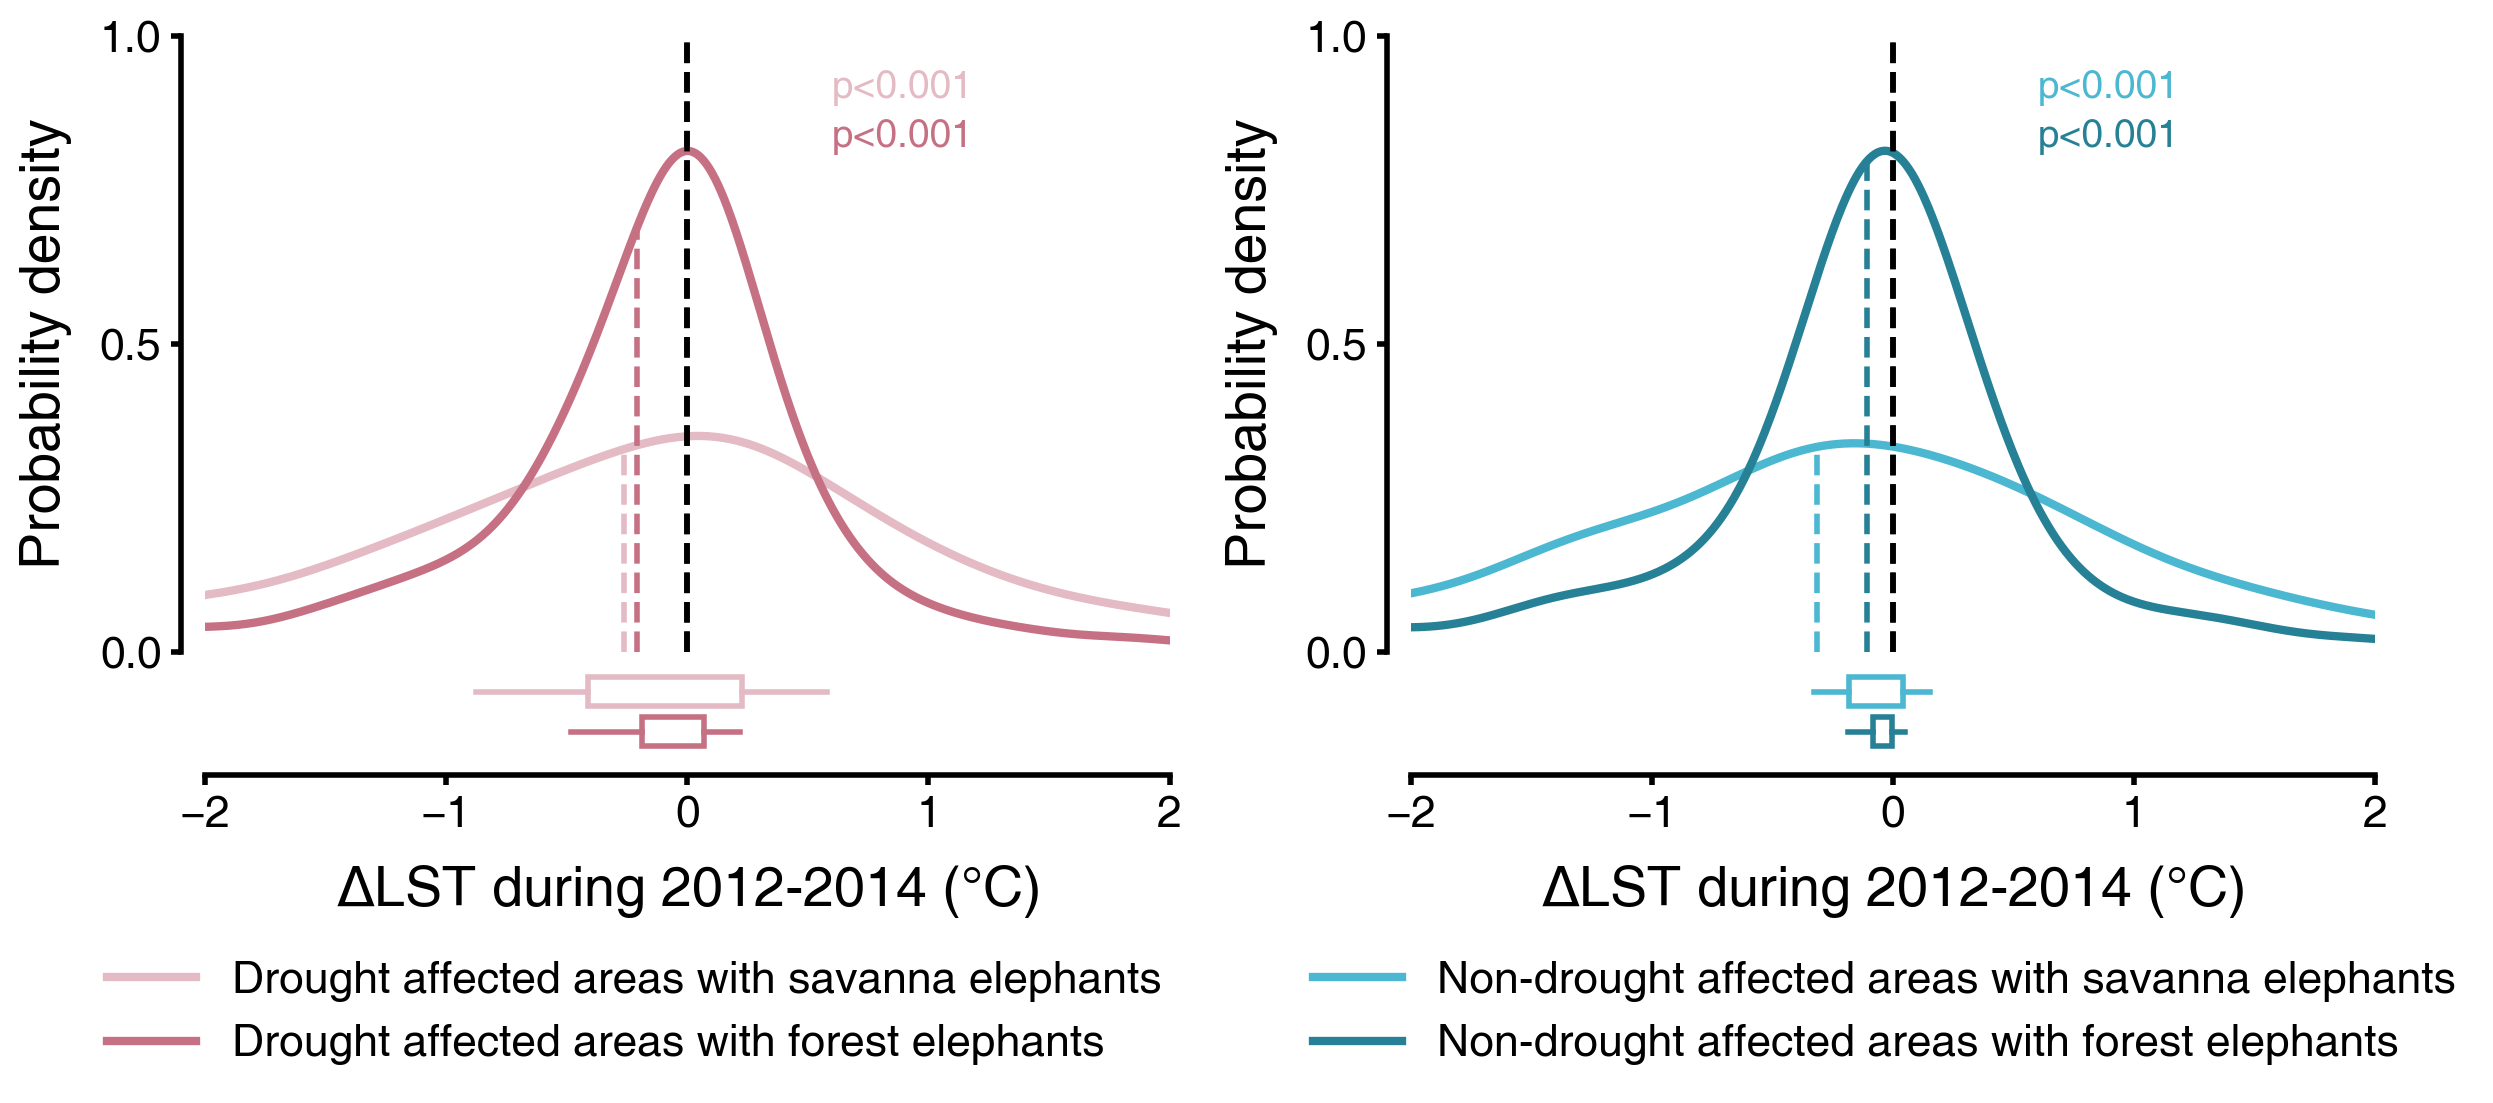

In [34]:
#-*- coding:utf-8 –*-
import gloce as gc
from scipy.stats import gaussian_kde
import matplotlib.colors as mcolors
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig = plt.figure(figsize=(14,4)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.25,hspace=0.02)
#fig.subplots_adjust(wspace=0.2,hspace=0.4, left=None, bottom=None, right=None, top=None)
font = {'family': 'sans-serif',
        'sans-serif': 'Helvetica',
        'weight': 'normal',
        'size': 16}
plt.rc('font', **font)  #pass in the font dict as kwargs
#pp=[p_delta_LA[1],p_delta_LA[0]]
#pp1=[p_delta_LC[1],p_delta_LC[0]]
#cl= np.array([(211,145,161),(231,195,204),(44,149,174),(115,200,219)])
cl1= np.array([(228,186,196),(198,112,132)])
cl2=np.array([(75,183,209),(38,129,150)])
cl=[cl1/255,cl2/255]
cl2=['C0','salmon']
label=[['Drought affected areas with savanna elephants','Drought affected areas with forest elephants'],
       ['Non-drought affected areas with savanna elephants','Non-drought affected areas with forest elephants']]
xlabel=['$\Delta$LST during 2012-2014 (°C)','$\Delta$LST during 2012-2014 (°C)']
#colors = ['coral','yellowgreen','green','orange']
#lc3 = ['NF_BB','F_BB','F_NBB','NF_NBB']
#fig, axs=plt.subplots(2,2,sharex=True,sharey=True)
for i in range(2):
    ax = fig.add_subplot(1,2,i+1)
    ax.set_xlim(-2,2)
    ax.set_xticks(np.arange(-2,2.01,1))
    ax.set_ylim(0,1)
    ax.set_yticks(np.arange(0,1.1,0.5))
    ax=plt.gca()
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',-2.1))
    ax.spines['bottom'].set_position(('data',-0.2))
    ax.set_ylabel('Probability density',labelpad=10)
    ax.set_ylabel('Probability density',labelpad=10)
    ax.set_xlabel(xlabel[1],labelpad=10)
    ax.tick_params(labelsize=16)
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.xaxis.set_tick_params(width=2)
    ax.yaxis.set_tick_params(width=2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    for j in range(2):
        x=np.linspace(-3,3,1000)
        mean=np.nanmean(df_delta[i][j])
        delta_rav=gc.nanravel(df_delta[i][j])
        kenal=gaussian_kde(delta_rav)
        z=kenal.evaluate(x)
        z_mean=kenal.evaluate(mean)
        print(mean,z_mean)
        ax.plot(x,z,lw=3,color=cl[i][j],label=label[i][j])
        ax.vlines(mean,0,z_mean,lw=2,ls='--',color=cl[i][j])
        ax.vlines(0,0,1,lw=2,ls='--',color='black')
        if pp[i][j]<0.001:
            ax.text(0.65,0.90-j*0.08, 'p<0.001'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.01:
            ax.text(0.65,0.90-j*0.08, 'p<0.01'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        elif pp[i][j]<0.05:
            ax.text(0.65,0.90-j*0.08, 'p<0.05'.format(mean), fontsize=14,transform = ax.transAxes,color=cl[i][j])
        else:
            ax.text(0.65,0.90-j*0.08, 'p={:.2f}'.format(pp[i][j]), fontsize=14,transform = ax.transAxes,color=cl[i][j])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(fontsize=16,loc=(-0.12,-0.7),frameon=False)

    for j in range(2):
        if i ==0:
            if j ==0:
                ax1=fig.add_axes([0.122,-0,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.122,-0.05,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-5,5)
            ax1.set_xticks(np.arange(-5,5,2.5))
            ax1.axis('off')
        else:
            if j==0:
                ax1=fig.add_axes([0.55,-0,0.35,0.12])#左，底，宽，高
            else:
                ax1=fig.add_axes([0.55,-0.05,0.35,0.12])#左，底，宽，高
            ax1.set_xlim(-15,15)
            ax1.set_xticks(np.arange(-15,15,5))
            ax1.axis('off')
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)
        ax1.spines['left'].set_visible(False)
        ax1.tick_params(bottom=False,top=False, left=False, right=False)#隐藏刻度线
        #ax.spines['bottom'].set_visible(False)
        bplot=ax1.boxplot(df_delta[i][j],
                          vert=False,
                          whis=(10,90),                
                          widths=0.3,
                          patch_artist=True,
                          showmeans=False,
                          meanprops = {'marker':'o','markerfacecolor':cl[i][j],"markeredgecolor":cl[i][j],"markersize":15,"alpha":0}, # 设置均值点的属性，点的形状、填充色
                          medianprops={'linewidth':'0.5',"color":cl[i][j],"alpha":0},
                          boxprops={"facecolor": 'none', "edgecolor": cl[i][j],"linewidth":2,"alpha":1},
                          capprops=None,
                          whiskerprops={'linewidth':'2','color':cl[i][j]},
                          showcaps=False,# 是否显示箱线图顶端和末端的两条线，默认显示；
                          showfliers = False,
                          flierprops = {'marker':'+','markersize':'3','markeredgecolor':cl[i][j],'color':cl[i][j]})
